# Import

In [1]:
%matplotlib widget

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve

# Define

In [2]:
def compute_px(ppl, lls):
    lengths = np.array([len(ll) for ll in lls])
    logpx = np.log(ppl) * lengths * -1
    return logpx

def compute_auroc_all(id_msp, id_px, id_ppl, ood_msp, ood_px, ood_ppl, do_print=False):
    score_px = compute_auroc(-id_px, -ood_px)
    score_py = compute_auroc(-id_msp, -ood_msp)
    score_ppl = compute_auroc(id_ppl, ood_ppl)
    if do_print:
        print(f"P(x): {score_px:.3f}")
        print(f"P(y | x): {score_py:.3f}")
        print(f"Perplexity: {score_ppl:.3f}")
    scores = {
        'p_x': score_px,
        'p_y': score_py,
        'ppl': score_ppl
    }
    return scores

In [3]:
def compute_auroc(id_pps, ood_pps, normalize=False, return_curve=False):
    y = np.concatenate((np.ones_like(ood_pps), np.zeros_like(id_pps)))
    scores = np.concatenate((ood_pps, id_pps))
    if normalize:
        scores = (scores - scores.min()) / (scores.max() - scores.min())
    if return_curve:
        return roc_curve(y, scores)
    else:
        return 100*roc_auc_score(y, scores)

def compute_far(id_pps, ood_pps, rate=5):
    incorrect = len(id_pps[id_pps > np.percentile(ood_pps, rate)])
    return 100*incorrect / len(id_pps)

In [4]:
def compute_metric_all(id_msp, id_px, id_ppl, ood_msp, ood_px, ood_ppl, metric='auroc', do_print=False):
    if metric == 'auroc':
        score_px = compute_auroc(-id_px, -ood_px)
        score_py = compute_auroc(-id_msp, -ood_msp)
        score_ppl = compute_auroc(id_ppl, ood_ppl)
    elif metric == 'far':
        score_px = compute_far(-id_px, -ood_px)
        score_py = compute_far(-id_msp, -ood_msp)
        score_ppl = compute_far(id_ppl, ood_ppl)
    else:
        raise Exception('Invalid metric name')

    if do_print:
        print(f"Metric {metric}:")
        print(f"P(x): {score_px:.3f}")
        print(f"P(y | x): {score_py:.3f}")
        print(f"Perplexity: {score_ppl:.3f}\n")

    scores = {
        'p_x': score_px,
        'p_y': score_py,
        'ppl': score_ppl
    }
    return scores

In [5]:
def read_model_out(fname):
    ftype = fname.split('.')[1]
    
    if ftype == 'pkl':
        with open(fname, 'rb') as f:
            return pickle.load(f)
    elif ftype == 'npy':
        return np.load(fname)
    else:
        raise KeyError(f'{ftype} not supported')


# Summarize

## Presettings

In [6]:
verbose = False

In [7]:
repo = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
print(repo)

/Users/udit/code/nyu/fall20/NLP/ood-detection


In [8]:
output_dir = os.path.join(repo, 'output')
fig_dir = os.path.join(repo, 'figs')

In [9]:
train_sets = ['imdb', 'sst2']
eval_sets = ['imdb', 'sst2', 'snli', 'counterfactual-imdb']
methods = ['msp', 'lls', 'pps']

signals = {}
for train_set in train_sets:
    for eval_set in eval_sets:
        signals[(train_set, eval_set)] = {method: None for method in methods}

## Import Signals

In [10]:
method2ftype={
    'msp': 'npy',
    'lls': 'pkl',
    'pps': 'npy',
}

### GPT2

In [11]:
best_lr = {
    'imdb': '5e-5',
    'sst2': '5e-5',
}

methods = ['lls', 'pps']
not_readys = []

for (train_set, eval_set), signals_dict in signals.items():
    for method in methods:
        signal_fname = os.path.join(output_dir, 'gpt2', train_set, f'{eval_set}_{best_lr[train_set]}_{method}.{method2ftype[method]}')
        if not os.path.exists(signal_fname):
            not_readys.append((train_set, eval_set, method))
            continue

        signals_dict[method] = read_model_out(signal_fname)
        
for not_ready in not_readys:
    print(not_ready)

('sst2', 'counterfactual-imdb', 'lls')
('sst2', 'counterfactual-imdb', 'pps')


### RoBERTa

In [12]:
methods = ['msp']
not_readys = []

model_type = 'roberta-large'

for (train_set, eval_set), signals_dict in signals.items():
    for method in methods:
        signal_fname = os.path.join(output_dir, 'roberta', train_set, f'{model_type}_{eval_set}_{method}.{method2ftype[method]}')
        if not os.path.exists(signal_fname):
            not_readys.append((train_set, eval_set, method))
            continue

        signals_dict[method] = read_model_out(signal_fname)
        
for not_ready in not_readys:
    print(not_ready)

## Summarize Evals

In [13]:
metrics = ['auroc', 'far']

metric_summary = []

score2plot = {
    'p_x': r'GPT2: $p(x)$',
    'ppl': 'GPT2: PPL',
    'p_y': 'RoBERTa: MSP',
}

metric2plot = {
    'auroc': 'AUROC',
    'far': 'FAR95'
}

dataset2plot = {
    'imdb': 'IMDB',
    'sst2': 'SST-2',
    'snli': 'SNLI',
    'counterfactual-imdb': 'cIMDB',
}

not_ready = []
for train_set in train_sets:
    for eval_set in eval_sets:
        if train_set == eval_set:
            continue
        
        ood_signal_dict = signals[(train_set, eval_set)]
        id_signal_dict = signals[(train_set, train_set)]
        
        skip=False
        for value in ood_signal_dict.values():
            if isinstance(value, type(None)):
                skip=True
                
        if skip:
            not_ready.append((train_set, eval_set))
            continue
            
        ood_px = compute_px(ood_signal_dict['pps'], ood_signal_dict['lls'])
        id_px = compute_px(id_signal_dict['pps'], id_signal_dict['lls'])
               
        for metric in metrics:
            scores = compute_metric_all(
                id_msp=id_signal_dict['msp'],
                id_px=id_px,
                id_ppl=id_signal_dict['pps'],
                ood_msp=ood_signal_dict['msp'],
                ood_px=ood_px,
                ood_ppl=ood_signal_dict['pps'],
                metric=metric,
                do_print=verbose
            )
            
            for score_key, score_value in scores.items():
                row = {'Method': score2plot[score_key], 'score': score_value}
            
                row['in_domain'] = dataset2plot[train_set]
                row['out_domain'] = dataset2plot[eval_set]
                row['metric'] = metric2plot[metric]

                metric_summary.append(row)

print(pd.DataFrame(metric_summary))

          Method      score in_domain out_domain metric
0   GPT2: $p(x)$   0.410715      IMDB      SST-2  AUROC
1   RoBERTa: MSP  70.281889      IMDB      SST-2  AUROC
2      GPT2: PPL  91.266848      IMDB      SST-2  AUROC
3   GPT2: $p(x)$  99.988000      IMDB      SST-2  FAR95
4   RoBERTa: MSP  80.905000      IMDB      SST-2  FAR95
5      GPT2: PPL  50.696000      IMDB      SST-2  FAR95
6   GPT2: $p(x)$   0.185626      IMDB       SNLI  AUROC
7   RoBERTa: MSP  94.410856      IMDB       SNLI  AUROC
8      GPT2: PPL  71.329543      IMDB       SNLI  AUROC
9   GPT2: $p(x)$  99.968000      IMDB       SNLI  FAR95
10  RoBERTa: MSP  14.000000      IMDB       SNLI  FAR95
11     GPT2: PPL  91.144000      IMDB       SNLI  FAR95
12  GPT2: $p(x)$  41.396310      IMDB      cIMDB  AUROC
13  RoBERTa: MSP  63.987969      IMDB      cIMDB  AUROC
14     GPT2: PPL  55.149367      IMDB      cIMDB  AUROC
15  GPT2: $p(x)$  94.688000      IMDB      cIMDB  FAR95
16  RoBERTa: MSP  81.240000      IMDB      cIMDB

# Plot

In [14]:
title_size=24
label_size=18
annot_size=14

In [15]:
def my_plot(
    df=None,
    x='out_domain',
    y='score',
    hue='Method',
    title=None,
    xlabel='',
    ylabel='',
    palette='colorblind',
    ylim=[0,110],
    yticks=np.arange(0,110,20),
    order=None,
    val_offset = 5,
    hue_order=None,
    figsize=(10,5)
):
    
    fig, ax = plt.subplots(figsize=figsize)
    splot = sns.barplot(
        data=df, 
        x=x, 
        y=y,
        hue=hue,
        palette=palette,
        hue_order=hue_order,
    )
    
    for p in splot.patches:
        splot.annotate(
            f'{p.get_height():.1f}',
            (p.get_x() + p.get_width() / 2, p.get_height() + val_offset),
            ha='center', va='center',
            fontsize=annot_size
        )
    
    if not title is None:
        ax.set_title(title, fontsize=title_size)
        
    ax.set_xlabel(xlabel, fontsize=label_size)
    ax.set_ylabel(ylabel, fontsize=label_size)
        
    ax.legend(loc='upper left')
    ax.set_ylim(ylim)
    
    splot.set_yticklabels(yticks, size=annot_size)
    splot.set_xticklabels(order, size=annot_size)
    
    fig.tight_layout()  
    
    return fig

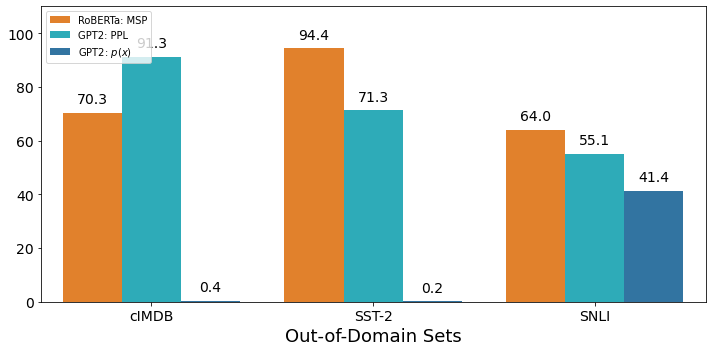

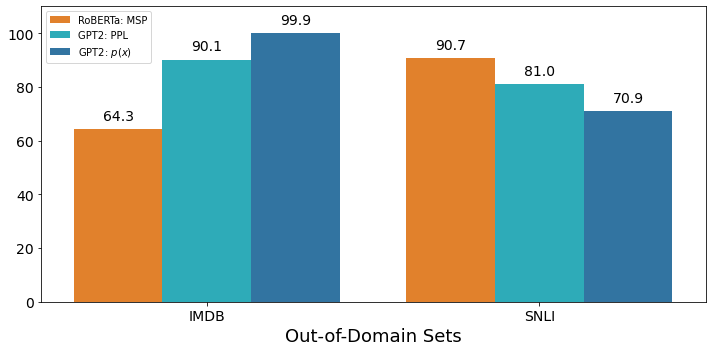

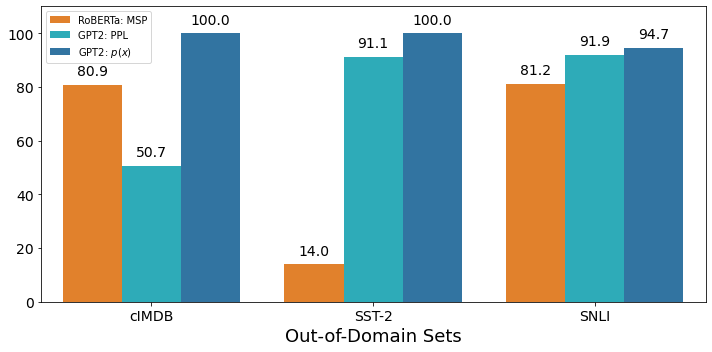

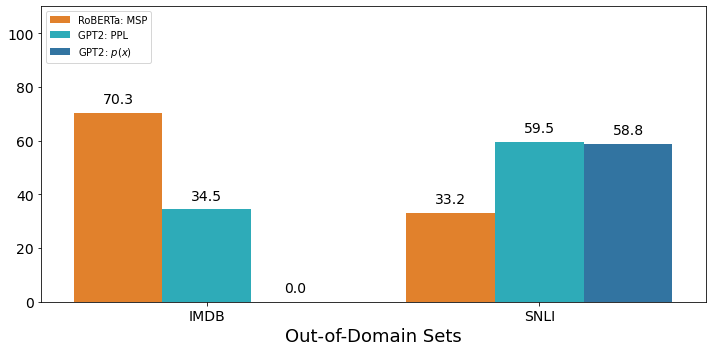

In [16]:
summary_df = pd.DataFrame(metric_summary)
xlabel = 'Out-of-Domain Sets'

order_all = ['cIMDB', 'IMDB', 'SST-2', 'SNLI']
hue_order = ['RoBERTa: MSP',  'GPT2: PPL', r'GPT2: $p(x)$']
palette = {
    'RoBERTa: MSP':'tab:orange',
    'GPT2: PPL':'tab:cyan',
    r'GPT2: $p(x)$':'tab:blue',
}
figsize = (10, 5)

save = True
fig_ftype = 'jpg'

for metric in summary_df['metric'].unique():
    sub_df = summary_df.loc[summary_df['metric'] == metric, :]
    
    for in_domain in sub_df['in_domain'].unique():
        subsub_df = sub_df.loc[sub_df['in_domain'] == in_domain, :]
        
        order=[out_domain for out_domain in order_all if out_domain in subsub_df['out_domain'].unique()]
        
        fig = my_plot(
            df=subsub_df,
#             title=f'{in_domain}',
            xlabel=xlabel,
#             ylabel=metric,
            order=order,
            hue_order=hue_order,
            palette=palette,
            figsize=figsize,
        )
        
        if save:
            os.makedirs(fig_dir, exist_ok=True)
            fig.savefig(os.path.join(fig_dir, f'{in_domain}_{metric}.{fig_ftype}'))

# Legacy

### IMDB as ID vs SST-2 as OOD

ppl_base_path = '../output/gpt2/sst2/'

imdb_pps = np.load(ppl_base_path + 'imdb_5e-5_pps.npy')
sst2_pps = np.load(ppl_base_path + 'sst2_5e-5_pps.npy')

with open(ppl_base_path + 'imdb_5e-5_lls.pkl', 'rb') as f:
    imdb_lls = pickle.load(f)

with open(ppl_base_path + 'sst2_5e-5_lls.pkl', 'rb') as f:
    sst2_lls = pickle.load(f)

msp_base_path = '../roberta/msp/'

imdb_msp = np.load(msp_base_path + 'large_imdb_msp.npy')
# imdb_msp = np.load(msp_base_path + 'textattack_imdb_msp.npy')
sst2_msp = np.load(msp_base_path + 'large_sst2_msp.npy')

all_pps = {
    'imdb': imdb_pps,
#     'yelp': yelp_pps,
    'sst2': sst2_pps,
#     'snli': snli_pps,
#     'rte': rte_pps
}

all_lls = {
    'imdb': imdb_lls,
#     'yelp': yelp_lls,
    'sst2': sst2_lls,
#     'snli': snli_lls,
#     'rte': rte_lls
}

all_msp = {
    'imdb': imdb_msp,
#     'yelp': yelp_msp,
    'sst2': sst2_msp,
#     'snli': snli_msp,
#     'rte': rte_msp
}

all_px, all_pxy = {}, {}
for ds in all_pps.keys():
    all_px[ds] = compute_px(all_pps[ds], all_lls[ds])

dataset_pairs = [('sst2', 'imdb')]
metrics = ['auroc', 'far']

for (id_name, ood_name) in dataset_pairs:
    print(f"-------{id_name} vs {ood_name}-------")
    for metric in metrics:
        compute_metric_all(all_msp[id_name], all_px[id_name],
                           all_pps[id_name], all_msp[ood_name],
                           all_px[ood_name], all_pps[ood_name], metric=metric, do_print=True)

results = {}

for metric in metrics:
    results[metric] = {}
    for (id_name, ood_name) in dataset_pairs:
        results[metric][f'{id_name}-{ood_name}'] = compute_metric_all(all_msp[id_name], all_px[id_name],
                           all_pps[id_name], all_msp[ood_name],
                           all_px[ood_name], all_pps[ood_name], metric=metric)

all_dfs = {}

for metric in metrics:
    all_dfs[metric] = pd.DataFrame.from_dict(results[metric], orient='index')

print("AUROC:")

all_dfs['auroc']

print("FAR95:")

all_dfs['far']